In [87]:
import pandas as pd

from functions import *
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


In [88]:
# считываем данные из текстового файла
df = pd.read_csv('../data/casting_data.csv')

In [89]:
df.head(5)

,Data case no.,Sprue_SA,Sprue_SB,Sprue_SC,Sprue_SD,Gate_GE,Gate_GF,Ingate velocity (m s-1),Jet high (mm),Data type
0,1,155,19,5.0,12,35,5.0,0.93,32.82,Training
1,2,155,21,7.5,14,40,7.5,1.17,42.15,Training
2,3,155,23,10.0,16,45,10.0,1.44,55.76,Training
3,4,155,25,12.5,18,50,12.5,1.48,57.98,Training
4,5,155,27,15.0,20,55,15.0,1.56,64.85,Training


In [90]:
# Разбиваем данные на данные для тестирования и для обучения
X_train = df[df['Data type'] != 'Test']
y_train = X_train['Jet high (mm)'].to_numpy()
X_train = X_train.drop(['Data case no.', 'Jet high (mm)', 'Data type', 'Ingate velocity (m s-1)'], axis = 1).to_numpy()

X_test = df[df['Data type'] != 'Training']
y_test = X_test ['Jet high (mm)'].to_numpy()
X_test = X_test.drop(['Data case no.', 'Jet high (mm)', 'Data type', 'Ingate velocity (m s-1)'], axis = 1).to_numpy() 


In [91]:
# Масштабируем данные
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

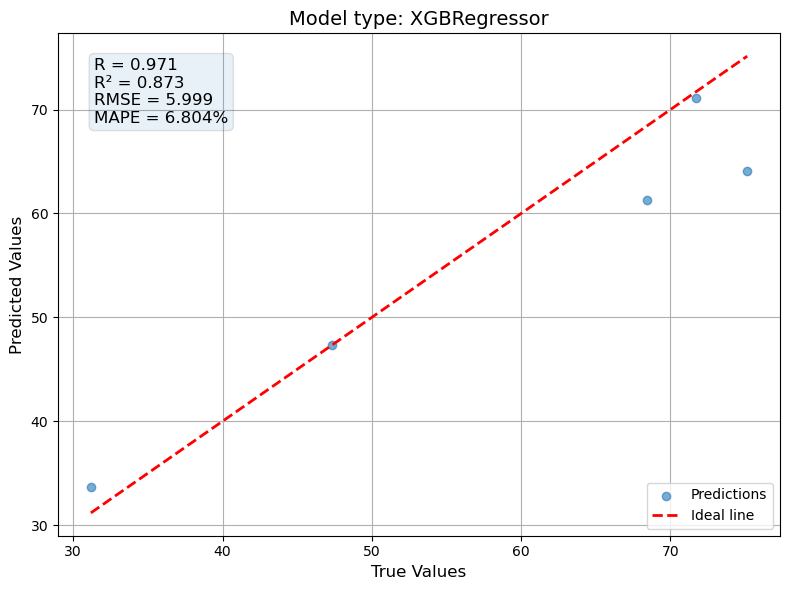

In [92]:
# Обучение модели (на основе XGBRegressor)
# создаем модель
model = XGBRegressor(
                    n_estimators=100,
                    max_depth=2,
                    learning_rate=0.1,
                    reg_alpha=0.5,
                    reg_lambda=0.1,
                    subsample=0.9,
                    random_state=1488,
                    verbosity=0
                    )
# обучаем модель
model.fit(X_train_scaled, y_train);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(X_test_scaled)

# Посмотрим на график паритета
title = "Model type: XGBRegressor"
plot_true_vs_predicted(y_test, y_pred_test,  title=title)

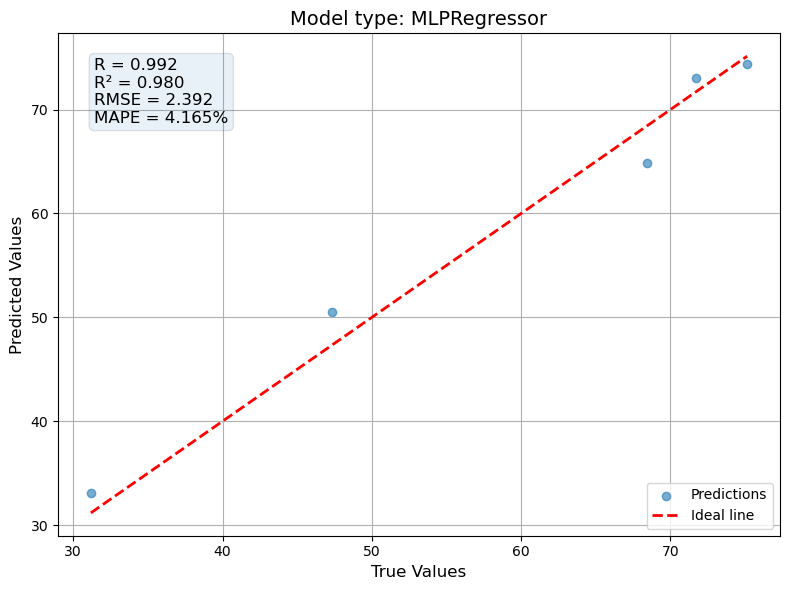

In [93]:
# Обучение модели (на основе MLPRegressor)
# создаем модель
model = MLPRegressor(
        hidden_layer_sizes=(14,),  # [6-14-1]
        activation='tanh',         # tansig
        solver='lbfgs',           # Ближе к LM, чем 'adam'
        alpha=0.001,             # Регуляризация L2
        max_iter=10000,
        random_state=1488,
        verbose=True
        )

# обучаем модель
model.fit(X_train_scaled, y_train);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(X_test_scaled)

# Посмотрим на график паритета
title = "Model type: MLPRegressor"
plot_true_vs_predicted(y_test, y_pred_test,  title=title)

Оптимальное alpha: 0.001


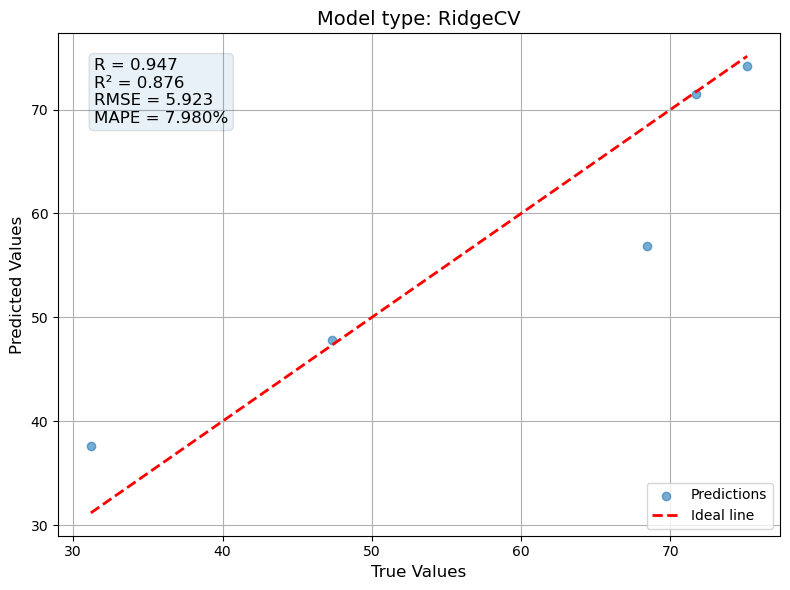

In [96]:
# Обучение модели (на основе RidgeCV)
# создаем модель
# Логарифмическая сетка значений alpha для перебора
alphas = np.logspace(-3, 2, 50)  # от 0.0001 до 100



# Создаём пайплайн: полином 2-й степени + линейная регрессия
model = Pipeline([
                ('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only = False, order='F')),
                ('RidgeCV', RidgeCV(
                                    alphas=alphas,
                                    fit_intercept=False,   # потому что include_bias=True уже добавляет столбец единиц
                                    cv=5,                  # можно указать число фолдов или объект CV
                                    store_cv_results=False ))
                ])

# Train the model using the training sets
model.fit(X_train_scaled, y_train);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(X_test_scaled)

# посмотрим на оптимальное значение alpha
print(f"Оптимальное alpha: {model.named_steps['RidgeCV'].alpha_}")

# Посмотрим на график паритета
title = "Model type: RidgeCV"
plot_true_vs_predicted(y_test, y_pred_test,  title=title)